- 贝尔曼方程的逐步推导与直观含义
- 标量形式与矩阵形式
- 解析解 `(I - γP)^{-1} R`（当可逆时）
- 迭代解（贝尔曼备份 / 动态规划）与其收敛行为
- 与 Monte Carlo 估计比较
- 两个直观例子：走廊机器人与库存（inventory）简单模型

In [21]:
# 基础库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 便于显示大矩阵（notebook 环境下）
np.set_printoptions(precision=4, suppress=True)


## 1) 定义一个小的 MRP（马尔可夫奖励过程）用于示范
我们用之前的“7 房间走廊”示例（s1..s7）：
- 奖励向量 R = [5,0,0,0,0,0,10]
- 简单随机游走转移 P（内部向左/向右 0.5，边界反射）
- 折扣因子 γ（可调整）

In [22]:
# --------- MRP 定义 ----------
N = 7  # 状态数 s1..s7
R = np.array([5, 0, 0, 0, 0, 0, 10], dtype=float)  # 即时奖励（进入某状态获得的奖励）
gamma = 0.5  # 折扣因子（可改为其他值试验）

# 构建转移矩阵 P（随机游走 + 边界反射）
P = np.zeros((N, N))
for i in range(N):
    if i == 0:
        P[i, 0] = 0.5  # s1 保留 50%
        P[i, 1] = 0.5  # s1 -> s2
    elif i == N - 1:
        P[i, N-1] = 0.5
        P[i, N-2] = 0.5
    else:
        P[i, i-1] = 0.5
        P[i, i+1] = 0.5

# 打印检查
print("奖励 R: ", R)
print("G: ", gamma)
print("转移矩阵 P (rows = current state, cols = next state):\n", P)


奖励 R:  [ 5.  0.  0.  0.  0.  0. 10.]
G:  0.5
转移矩阵 P (rows = current state, cols = next state):
 [[0.5 0.5 0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.5 0.5]]


### 标量贝尔曼方程回顾（单个状态）
贝尔曼方程（标量形式）：
V(s) = R(s) + γ * Σ_{s'} p(s' | s) V(s')

直观含义：
- 当前状态的价值 = 立即能拿到的奖励 + 折扣后的“未来状态的期望价值”

In [23]:
# 逐状态打印贝尔曼方程中的右边各项，便于理解
V_dummy = np.zeros(N)  # 随机的初始 V，用于演示 pV 项如何计算
rhs = R + gamma * (P @ V_dummy)  # R + γ Σ p(s'|s) V(s')
print("示例：当 V = 0 时，贝尔曼右侧等于即时奖励：")
for i in range(N):
    print(f"V({i+1}) = R({i+1}) + γ Σ p(s'|s{i+1}) V(s') = {rhs[i]:.4f}")


示例：当 V = 0 时，贝尔曼右侧等于即时奖励：
V(1) = R(1) + γ Σ p(s'|s1) V(s') = 5.0000
V(2) = R(2) + γ Σ p(s'|s2) V(s') = 0.0000
V(3) = R(3) + γ Σ p(s'|s3) V(s') = 0.0000
V(4) = R(4) + γ Σ p(s'|s4) V(s') = 0.0000
V(5) = R(5) + γ Σ p(s'|s5) V(s') = 0.0000
V(6) = R(6) + γ Σ p(s'|s6) V(s') = 0.0000
V(7) = R(7) + γ Σ p(s'|s7) V(s') = 10.0000


## 2) 解析解（矩阵形式）： V = (I - γ P)^{-1} R
当 (I - γ P) 可逆时，我们可以一次性解出所有状态的价值：
V = (I - γ P)^{-1} R

这个方法非常直接，但对大状态空间计算量是 O(N^3)（矩阵求逆或线性求解）。

In [24]:
# 解析解（如果矩阵可逆）
I = np.eye(N)
try:
    V_analytic = np.linalg.solve(I - gamma * P, R)  # 比直接 inv() 更稳定
    print("解析解 V (analytic):\n", V_analytic)
except np.linalg.LinAlgError:
    V_analytic = None
    print("解析解无法计算：矩阵 (I - γP) 奇异或不可逆。")


解析解 V (analytic):
 [ 7.3274  1.9821  0.6012  0.4225  1.089   3.9334 14.6445]


## 可视化：显示状态价值（解析解）
下面画一个条形图展示 V(s)（如果解析解可用）。

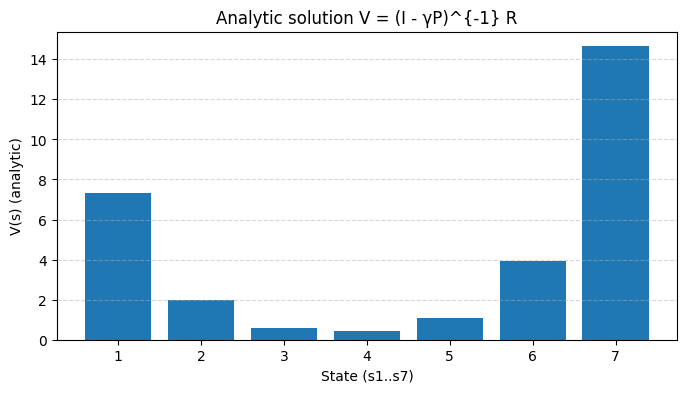

In [25]:
if V_analytic is not None:
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(1, N+1), V_analytic)
    plt.xlabel("State (s1..s7)")
    plt.ylabel("V(s) (analytic)")
    plt.title("Analytic solution V = (I - γP)^{-1} R")
    plt.xticks(np.arange(1, N+1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("解析解不可用，跳过可视化。")


## 3) 迭代贝尔曼备份（动态规划 / 直接迭代求解）
贝尔曼方程给出了一种自洽关系：V = R + γ P V。我们可以把它写成更新公式（一次贝尔曼备份）：
V_{k+1} = R + γ P V_k

反复迭代这一更新（从任意初始 V_0）会收敛到唯一的解（只要 γ < 1 且 P 是良性）。
我们在代码中演示收敛过程并可视化迭代轨迹。

In [26]:
def bellman_iteration(P, R, gamma, V0=None, max_iters=200, tol=1e-8, verbose=False):
    """使用简单的贝尔曼迭代 V_{k+1} = R + γ P V_k 来求解 V"""
    n = len(R)
    V = np.zeros(n) if V0 is None else V0.copy()
    history = [V.copy()]
    for k in range(max_iters):
        V_next = R + gamma * (P @ V)
        history.append(V_next.copy())
        if np.max(np.abs(V_next - V)) < tol:
            if verbose:
                print(f"收敛于第 {k+1} 步，max_delta = {np.max(np.abs(V_next-V)):.2e}")
            return V_next, np.array(history)
        V = V_next
    if verbose:
        print("达到最大迭代次数，未严格满足 tol。")
    return V, np.array(history)

V_iter, history = bellman_iteration(P, R, gamma, max_iters=2000, tol=1e-10, verbose=True)
print("迭代最终得到的 V:\n", V_iter)


收敛于第 36 步，max_delta = 6.36e-11
迭代最终得到的 V:
 [ 7.3274  1.9821  0.6012  0.4225  1.089   3.9334 14.6445]


## 迭代收敛可视化
接下来画出每个状态随迭代次数变化的曲线（收敛轨迹），以及迭代解与解析解的差别。

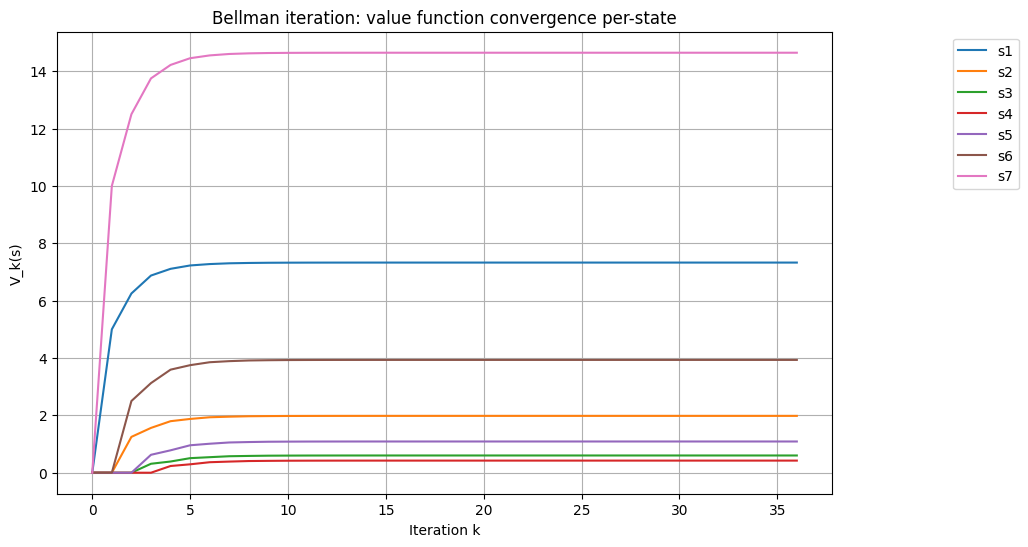

,state,V_iter,V_analytic,abs_diff
0,s1,7.327379,7.327379,6.157297e-11
1,s2,1.982137,1.982137,6.155054e-11
2,s3,0.601168,0.601168,6.219247e-11
3,s4,0.422535,0.422535,6.214129e-11
4,s5,1.088973,1.088973,6.294187e-11
5,s6,3.933356,3.933356,6.290080e-11
6,s7,14.644452,14.644452,6.325607e-11


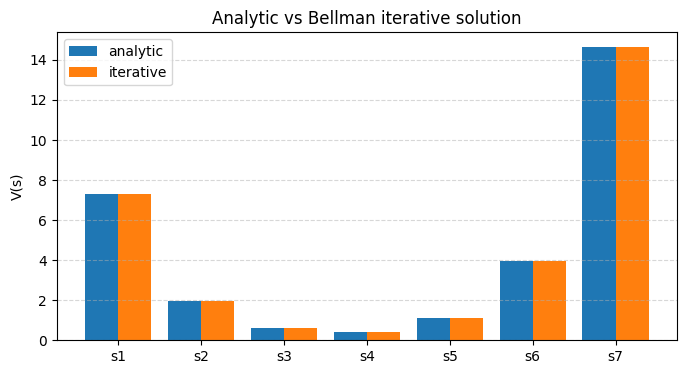

In [27]:
# 画每个状态 V_k 的收敛轨迹（只取前若干次以便查看）
iters_to_plot = min(history.shape[0], 200)
plt.figure(figsize=(10, 6))
for s in range(N):
    plt.plot(history[:iters_to_plot, s], label=f"s{s+1}")
plt.xlabel("Iteration k")
plt.ylabel("V_k(s)")
plt.title("Bellman iteration: value function convergence per-state")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.grid(True)
plt.show()

# 画迭代解 vs 解析解（如果解析解存在）
if V_analytic is not None:
    diff = np.abs(V_iter - V_analytic)
    df = pd.DataFrame({
        "state": [f"s{i+1}" for i in range(N)],
        "V_iter": V_iter,
        "V_analytic": V_analytic,
        "abs_diff": diff
    })
    display(df)
    plt.figure(figsize=(8,4))
    x = np.arange(1, N+1)
    plt.bar(x-0.2, V_analytic, width=0.4, label="analytic")
    plt.bar(x+0.2, V_iter, width=0.4, label="iterative")
    plt.xticks(x, [f"s{i}" for i in range(1, N+1)])
    plt.ylabel("V(s)")
    plt.title("Analytic vs Bellman iterative solution")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
else:
    print("无解析解供对比。")


## 4) Monte Carlo 对比（简单演示）
Monte Carlo 是直接用采样的方式估计状态的期望回报 E[G | s]：
- 从某个状态 s 出发，采样很多条 episode（按指定策略 / 自然转移）
- 每条 episode 计算折扣回报 G
- 对 G 求平均得到 V(s) 的估计

下面我们把 Monte Carlo 的估计和上面的结果做对比（例如对 s4）。

In [28]:
import random

HORIZON = 4  # 为对比用小 horizon（如你教科书示例）
def sample_episode_from(s0, horizon=HORIZON):
    """按 P 的概率从 s0 出发采样一个 finite-horizon episode，
       返回进入各后续状态的奖励序列（长度 = horizon）
    """
    s = s0
    rewards = []
    for _ in range(horizon):
        # 根据 P[s] 的分布采下一个状态
        s = np.random.choice(np.arange(N), p=P[s])
        rewards.append(R[s])  # 进入下一个状态获得的奖励
    return rewards

def mc_estimate_state(s0, n_episodes=5000, horizon=HORIZON):
    returns = []
    for _ in range(n_episodes):
        r = sample_episode_from(s0, horizon)
        G = sum((gamma**k) * r[k] for k in range(len(r)))
        returns.append(G)
    return np.mean(returns), np.std(returns), returns

# 对 s4 (index=3) 做 MC 估计
mc_mean, mc_std, mc_samples = mc_estimate_state(3, n_episodes=5000)
print(f"MC estimate V(s4) ~ {mc_mean:.4f} ± {mc_std:.4f} (std)")
print("迭代法 V(s4) =", V_iter[3], "解析解 V(s4) =", (V_analytic[3] if V_analytic is not None else None))


MC estimate V(s4) ~ 0.5553 ± 1.0940 (std)
迭代法 V(s4) = 0.42253521120546433 解析解 V(s4) = 0.4225352112676056


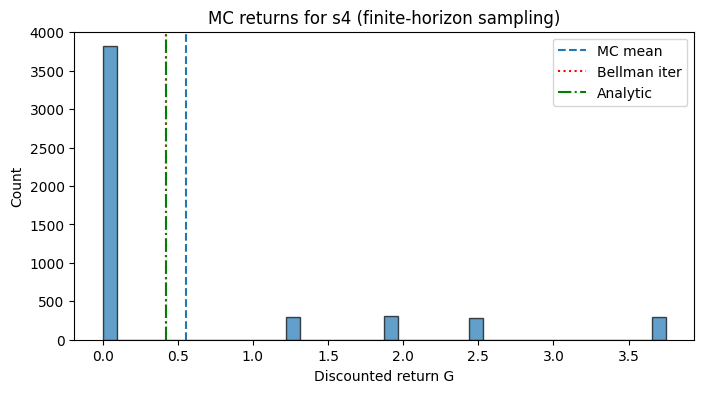

In [29]:
# 画 MC 回报的直方图，并与解析/迭代值画线比较
plt.figure(figsize=(8,4))
plt.hist(mc_samples, bins=40, density=False, alpha=0.7, edgecolor='black')
plt.axvline(mc_mean, linestyle='--', label='MC mean')
plt.axvline(V_iter[3], color='r', linestyle=':', label='Bellman iter')
if V_analytic is not None:
    plt.axvline(V_analytic[3], color='g', linestyle='-.', label='Analytic')
plt.title("MC returns for s4 (finite-horizon sampling)")
plt.xlabel("Discounted return G")
plt.ylabel("Count")
plt.legend()
plt.show()


## 5) 实际应用举例（直观理解）

### 例子 A：走廊机器人（我们一直在用）
- 机器人在 7 个房间随机行走（左右移动）
- s1 有小补给（5），s7 有大补给（10）
- V(s) 表示“站在房间 s 现在的价值”，也就是你现在站在该房间，未来能期望拿到的折扣收益
- 贝尔曼方程告诉我们每个房间的价值可以用它邻居房间的价值去更新（递归关系）

### 例子 B：超市库存（简化）
- 状态 = 存货水平（0..N）
- 每期（一步）可能发生需求（把库存变少）或补货（把库存变多）
- 立即奖励 R(s) 可以代表“每周期的利润”或“缺货惩罚”
- 我们用贝尔曼方程评估不同库存水平的长期预期收益，从而决定最优补货策略（这是策略评估 / 策略迭代的第一步）

上面两类问题在工程上都非常常见：机器人规划、库存管理、排队系统、客服系统等都可以用 MDP/贝尔曼方程建模并求解。

## 6) 关于矩阵解析解的局限与替代方法
- 解析解需要对 (I - γP) 求逆，复杂度 O(N^3)，当状态数 N 很大时不可行。
- 替代方法：
  - 迭代贝尔曼（基于矩阵乘法，每步 O(N^2) 或利用稀疏矩阵加速）
  - TD(0)、TD(λ)、异步更新、样本基方法（样本效率更高并能处理大状态空间）
  - 基于函数逼近（近似值函数、神经网络）用于超大 / 连续状态空间


# 小结与练习建议

1. 手工计算一个非常小的 MRP（例如 N=3）：
   - 写出 P、R、γ
   - 用手算贝尔曼方程解（代数解）
   - 用迭代法验证收敛

2. 改变 γ（例如 0.9、0.99、0.1）观察解析解与迭代收敛速度的变化。

3. 把 P 改为非对称转移（例如从 s2 更容易去 s7），观察 V(s) 的变化。

4. 把 horizon 设为“直到终止状态”并把 s1 与 s7 设为吸收（absorbing）状态，观察 Monte Carlo 与解析解是否一致。

如需我把上面的练习都写成可运行的 cell 并给出参考答案，我可以继续生成。
